# A room with a view: Using support vectors to predict room occupancy #

Notebook prepared by Evert van Doorn, e.a.vandoorn@gmail.com. Comments / feedback welcome.

Suppose you want to examine whether or not rooms are occupied. Perhaps you run a hotel, and want like to know when the rooms in your hotel are being used. You could manage a school, and want to know how often rooms are used outside of regular hours. Or your company may have a number of offices, and you'd like to know how many of your employees work from home on a given day. You could stand at the entrance all day and count, of course. Or you could get some sensors, and use python to automate a predictive model of whether a room is occupied or not.

In this notebook, we will use measurements of environmental variables to predict whether or not a room was occupied at each measured time point. I came across the data in the UCI machine learning repository at https://archive.ics.uci.edu, specifically https://archive.ics.uci.edu/ml/machine-learning-databases/00357/. The data was uploaded by Luis Candanedo, luismiguel.candanedoibarra@umons.ac.be, UMONS in Belgium.

The data set contains a date and time of measurement, along with: 
* the temperature in the room expressed in degrees Celcius; 
* the humidity in the room expressed in percentage points;
* the level of light in the room expressed in lux;
* the level of CO2 in the air in the room, expressed in parts per million;
* the humidity ratio (derived from temperature and humidity) expressed in kg of water vapor / kg of air.
* whether the room was occupied (value 1) or not (value 0)

All measurements relate to one office room, meaning that we are asking the question 'was the office room occupied, or not?'. This notebook provides an answer to that question. It consists of cells, which contain blocks of code or text. Every code cell has comments that explain operations in that cell. I've occasionally inserted markdown cells to explain decisions related to the analytic process in text.

We'll be using a Support Vector Classifier to tackle this problem. This classifier was not found to be effective in the original article (Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, Veronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39). 

We can say at the onset that the Support Vector Classifier is likely not the optimal choice of algorithm for tackling this problem, because of the relatively high computational load involved in transforming the dataset to higher dimensionality, which would not make it a very good option for continuous measurement or prediction of room occupancy. For science's sake, however, let's see if we can use the sklearn SVC algorithm to good effect on these data.

In [437]:
# To start, let's import some useful stuff
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import math
from seaborn import heatmap
from statsmodels.api import qqplot
from scipy.stats import multivariate_normal


# and set some matplotlib settings.
%matplotlib inline
mpl.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20, 6)

In [438]:
# Next, let's define some functions for later use (mostly for plotting purposes)

def correlation_heatmap(df):
    """Plot correaltions of a dataframe of columns with numeric datatypes in a heatmap plot"""
    colormap = plt.cm.viridis
    plt.figure(figsize=(12,12))
    plt.title('Pearson Correlation of Features ', y=1.05, size=15)
    heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
    plt.show()
    plt.clf()

def numvar_parallel_coordinates(df, categoricalCol):
    """Plot a parallel coordinates map of a dataframe of columns with numeric datatypes"""
    from pandas.tools.plotting import parallel_coordinates
    colormap = plt.cm.viridis
    plt.figure(figsize=(12,12))
    plt.title('Parallel Coordinates of Feature Space ', y=1.05, size=15)
    parallel_coordinates(df, categoricalCol)    
    plt.plot()
    plt.clf()
    
def numvar_andrews_curves(df, categoricalCol):
    """Plot an andrews curves graph of a dataframe of columns with numeric datatypes"""
    from pandas.plotting import andrews_curves
    colormap = plt.cm.viridis
    plt.figure(figsize=(12,12))
    plt.title('Andrews Curves for Feature Space ', y=1.05, size=15)
    andrews_curves(df, categoricalCol)    
    plt.show()
    plt.clf()
    
def numvar_hist(df, targetCol):
    """Plot histogram by feature in relation to both levels of target"""
    colormap = plt.cm.viridis
    for col in df.columns:
        if col == 'Occupancy':
            pass
        else:
            print(col)
            bins = np.linspace((df[col].min()*.9), (df[col].max()*1.1), 100)
            for val in df['Occupancy'].unique():
                plt.hist(df.loc[(df['Occupancy'] == val), col], bins, alpha=0.5, label=col)
            plt.legend(loc='upper right')
            plt.title(('Histogram ' + str(col)), y=1.05, size=15)
            plt.show()
            plt.clf()
             
            
def scale_features_df(df):
    """Autoscale features to have a mean of 0 (center around mean)"""
    scaled = sklearn.preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    
    print("New Variances:\n", scaled.var())
    print("New Describe:\n", scaled.describe())
    return scaled

def draw_vectors(transformed_features, components_, columns, plt):
    num_columns = len(columns)
    """Projects an *original* feature (columns) onto the 
    principal component feature-space, visualizing how "important" 
    each one was in the multi-dimensional scaling. Taken from Authman 
    Aphira's python course."""

    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        plt.arrow(0, 0, xvector[i], yvector[i], color='black', width=0.0005, head_width=0.02, alpha=1)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='black', alpha=1)

    return ax

def decision_function_2f(clf, X, y):
    """Takes classifier, X, and y, and plots the decision function for each datapoint on the grid. Taken from the sklearn documentation."""
    X = X.values[:, :2]     
    h = .02 

    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    title = 'SVC decision boundary for two principal components'

    plt.figure(figsize=(12,12))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.8) #was coolwarm

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

    plt.show()
    plt.clf()
    
        
def plot_validation_curve(classifier, X, y):
    """Takes a classifier and X and y data, and returns plots for classifier scores at various values of C and gamma. 
    Taken from the python sklearn documentation."""
    params = {'C': list(np.logspace(-6, 6, 5)), 'gamma':list(np.logspace(-6, 6, 5))}
    for param in params:
        train_scores, test_scores = validation_curve(
            classifier, X, y, param_name=param, param_range=params[param],
            cv=5, scoring="accuracy", n_jobs=1)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.title("Validation Curve with SVM")
        plt.xlabel(param)
        plt.ylabel("Score")
        plt.ylim(0.0, 1.1)
        lw = 2
        plt.semilogx(params[param], train_scores_mean, label="Training score",
            color="darkorange", lw=lw)
        plt.fill_between(params[param], train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std, alpha=0.2,
            color="darkorange", lw=lw)
        plt.semilogx(params[param], test_scores_mean, label="Cross-validation score",
            color="navy", lw=lw)
        plt.fill_between(params[param], test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std, alpha=0.2,
            color="navy", lw=lw)
        plt.legend(loc="best")
        plt.show()
        plt.clf()
 
        
        

In [439]:
# Originally, the data set consists of three collections of measurements (meant to function as training, testing and validation sets).
# As we want to use cross-validation, let's concatenate all data sets into one. 
file1 = pd.read_csv('datatest.txt', header = 0, sep = ',')
file2 = pd.read_csv('datatest2.txt', header = 0, sep = ',')
file3 = pd.read_csv('datatraining.txt', header = 0, sep = ',')
df = pd.concat([file1, file2, file3], axis = 0)
print(df.head(5))
print(df.shape)

                    date  Temperature  Humidity       Light         CO2  \
140  2015-02-02 14:19:00      23.7000    26.272  585.200000  749.200000   
141  2015-02-02 14:19:59      23.7180    26.290  578.400000  760.400000   
142  2015-02-02 14:21:00      23.7300    26.230  572.666667  769.666667   
143  2015-02-02 14:22:00      23.7225    26.125  493.750000  774.750000   
144  2015-02-02 14:23:00      23.7540    26.200  488.600000  779.000000   

     HumidityRatio  Occupancy  
140       0.004764          1  
141       0.004773          1  
142       0.004765          1  
143       0.004744          1  
144       0.004767          1  
(20560, 7)


First data point: 2015-02-02 14:19:00
Last data point: 2015-02-18 09:19:00


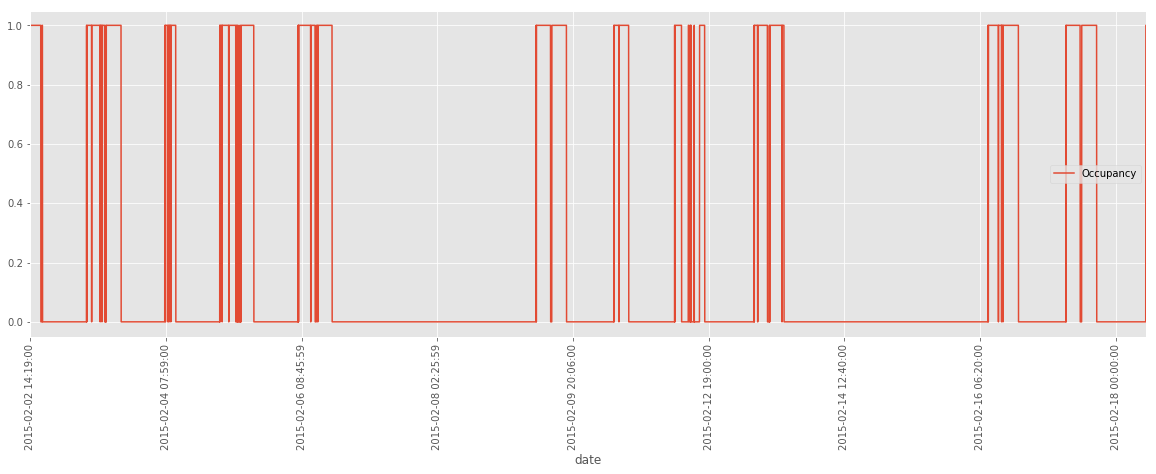

In [440]:
# As a starting point for our examination, let's look at the time series inherent in the data. 
# First, we can examine the first and last measurements
print('First data point: ' + str(min(df['date'])))
print('Last data point: ' + str(max(df['date'])))
# Then, we can look at the pattern of occupancy over time, to get a sense of how important the time feature is. 
df_timeplot = df.sort_values('date')
df_timeplot.plot(x = 'date', y = 'Occupancy', kind = 'line')
plt.xticks(rotation=90)
plt.show()
plt.clf()

## Modeling objective ##

The above graph shows that there are consecutive (daily) periods of use, separated by either short periods of disuse (nights) or longer periods of disuse (weekends). We can see that each period has several vertical lines in it, showing that room occupancy changes during the day. 

When data varies with a similar pattern over each period in time, this is called 'seasonality'. The above plot shows that our data has seasonality at at least two levels: weekly seasonality because there is no occupany over the weekends, and daily seasonality because occupancy falls between roughly the same hours each weekday. Also, only 4 periods of consecutive activity were measured in the week starting with Monday the 9th of February. Because these four periods of occupancy are evenly spaced and the periods of non-occupancy for the weekends are of comparable length suggests we are missing one day of measurements. We'll check this below. 

To analzye data with seasonal patterns, we would normally use a time series model with a state space decomposition. Such a model should be used for analyzing continuous sensory input, because the levels of all measured features depend directly on time. This holds for occupancy (as discussed above), but also for our predictive features. For example, concentrations of CO2 and moisture in a room tend to build up and decay over time, and natural light follows a 24-hour cycle that will predict the amount of lux a sensor captures in the absence of artificial lighting (i.e. when a room is not used).

Given that our dataset is:
* describing a time window of limited length;
* collected in one registration period interrupted for at most two days at a time;
* likely collected in the same office space,

we cannot build a model that generalizes over longer periods of time, between various office environments, or between combinations of these factors. *Given these restrictions, our initial objective with this dataset is to construct a model that allows us to describe when the office room in which the sensors were positioned was occupied, based on sensor readings but disregarding their time series properties.* 

We will not formally model any temporal seasonality for now, as we don't have enough data points to reliably estimate seasonal components. We'll also refrain from building a predictive model, as such a model would need to include seasonality to reach reliable predictions. 

Future models (both descriptive and predictive) should incorporate seasonality, and seek to generalize across offices with varying characteristics. Also, as the number of people in a room was not recorded, it seems worthwhile to explore the relation between sensor accuracy and the number of people occupying a room in later investigations.

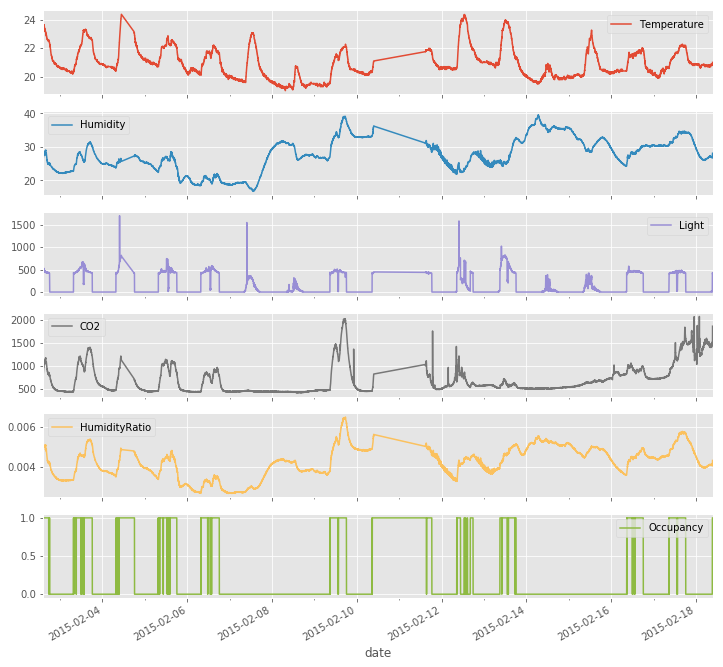

2      581
3     1440
4     1013
5     1440
6     1440
7     1440
8     1440
9     1440
10     574
11     552
12    1440
13    1440
14    1440
15    1440
16    1440
17    1440
18     560
Name: day, dtype: int64


In [441]:
# Although we are not modeling dependencies over time, it is important to include time a factor that influences variance.
# To do so, we can include components of the time stamp at which measurements took place as features.
# We change the data type of the 'date' field to datetime
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M:%S')

# This makes it easier to visualize time series for each observed variable by plotting them against time
df.plot.line(x=df['date'], subplots=True, figsize = (12,12))
plt.show()
plt.clf()
    
# Next, we separate out days, hours, minutes. In some cases, the sensors registered values one to a few seconds early. We'll recode these into the minutes they are related to. 
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day
df['hour']=df['date'].dt.hour
df['minute']=df['date'].dt.minute
df.loc[(df['date'].dt.second > 30),'minute']+=1

# We need to check if we indeed have missing values around 11-02-2015. If this is the case, frequency counts should differ between dates
print(df['day'].value_counts().sort_index())



### Feature interpretation and sampling strategy ###
The time series plots above show the expected, seasonal patterns for each of our features, and our target. For example, there are clear, recurrent patterns for temperature and light. We can also see that measurements took place in three time periods, with gaps between the 4th and 5th of February and the 10th and 12th of February. 

As we can see from the 'Occupancy' subgraph, the target variable is imbalanced. Currently, roughly 25% of the data set (4750 out of 20560 samples) involved an occupied room. In order for our learning algorithm to function well, we will need to correct this imbalance. 

First, we can examine only weekdays. This removes four days' worth of non-occupancy data points, but it will still leave a ratio of ocupancy timepoints to non-occupancy time points of roughly 1:2. Given the size of our dataset, we don't strictly need to compensate for this inequality. However, if at a later time we want to reliably estimate occupancy over longer periods of time, there are three strategies to deal with inequality which we can try out on this dataset. We can adjust the class weights applied to the C parameter, we can oversample, or we can undersample. 

#### Oversampling: SMOTE ####

To oversample, we can use the SMOTE function from the imblearn package. SMOTE uses k-nearest-neighbors to generate new samples within the existing sample space. When we generate new samples, we don't control exactly where these samples will fall in the sample space. Because we use a kernel, we can be sure that any errors that result from generating new samples will be evenly distributed across the sample space. 

Time series data has one dimension, time, in which data points are unique. The time dimension makes them a peculiar type of data, because time data points depend on preceding and successive points in patterns. This makes it difficult to apply oversampling, because if the oversampling algorithm does not take into account the necessary uniqueness of the timestamp data, it complictes the estimation of time-related patterns. 

Fortunately, the technique of generating new samples in a sample space has recently been adapted to also be used with time data (e.g. Cao, Li, Woon & Ng, 2013, *IEEE Transactions on knowledge and data engineering*). Unfortunately, however, this adaptation is not yet available in python. As can be seen from the comparisons in the Cao et al article, SMOTE at least offers a reasonable alternative pending implementation of the new technique in python. We will therefore use it here.

It is worth noting that as we are not treating the data as a continuous series (i.e. a time series) at this point, the specific disadvantages of applying SMOTE to time series do not apply.


#### Undersampling ####

In order to balance a time series with an imbalanced target variable, we can also selectively remove values from the time series. A framework of algorithms for doing so was recently proposed (Moniz, Branco & Torgo, 2017, *International journal of data science and analytics*). However these methods do not (as far as I am aware) support multivariate time series and have not been implemented in python at this time.

Implementing undersampling is problematic for time series for the opposite reason oversampling is; if data points are randomly not included in the model, the time-based dependencies of the model may become more difficult to estimate. As there is no method to implement undersampling for data sets with multiple seasonality at this point in time, we should prefer oversampling to undersampling.

As we are not treating our data as a continuous series we could randomly remove cases from our observations. That the sampling of data points to be removed occurs at random guarantees the general patterns in the data to be retained, even if the continuity of the time series is compromised.


#### Adjusting C weights ####

SKLearn offers the option of adjusting the weigths of the C-parameter, used for regularization of regression coefficients, based on the ratio between classes of the target variable. The logic behind this is that if one class is less common than the others, regularizing the coefficients for that class to a lesser extent (i.e. allowing them more variance) should enhance their predictive effects compared to the other, more regularized class in a magnitude comparable to the observed ratio. 

This approach attempts to 'correct' the variance explained by the two classes by changing the relative importance of each class. This means that the various parameters and metrics for the whole model stop being representative of the observed data points. Also, because we change the resulting parameters rather than the actual data points makes it difficult to estimate whether the impact of the transformation is in any way correlated with effects of features within the model itself.   


### TL; DR: ###

We need to correct imbalance of our target variable, and we can do so using 3 approaches. Each is suboptimal in its own way, in that they fail to accurately capture the influence of time in our data and introduce bias in results. Each strategy has its specific disadvantages: 
* If we change the weight of the C parameter to compensate for inequality of samples, we will distort parameter estimates (evaluation scores, accuracy) for the observed situation, and its impct on the relation between parameters and effects of features (including time-related features) is unclear; 
* If we use SMOTE,  we will distort parameter estimates (evaluation scores, accuracy) for the observed situation, and measurement error can increase as SMOTE adds permutations of existing measurements to the dataset. We will at this time not be able to accurately model the influence of time-related factors (e.g. seasonal influences, AR and MA components) on our data, and timestamps may be duplicated if the k-nearest-neighbors algorithm is agnostic to their uniqueness;
* If we use undersampling by random selection,  we will distort parameter estimates (evaluation scores, accuracy) for the observed situation, as we delete random cases with a value of 0 for 'Occupancy' from our dataset. This leads to discontinuity in our time series, making it impossible to estimate the influence of time-related factors if we would want to. If we remove cases, the pattern of removals may also affect our parameters. To obtain an unbiased estimate, we will have to cross-validate our undersampling.

Although each of these strategies seems suboptimal given the dataset, we can still use them to see if a predictive model of room occupancy can be formulated. We can also try to compare results in an effort to see which of these three approaches provides the best (or elast bad) basis for future predictions of whether an office is occupied.



In [442]:
# First, let's verify we have imbalanced data for our target 'Occupancy'
# We should see a mean value < .5 for 'Occupancy' if this is the case
print(df.describe())

# We can take out the weekends
print(df.shape)
df = df.loc[((df['date'] < '2015-02-07')|(df['date'] > '2015-02-08')),:]
df = df.loc[((df['date'] < '2015-02-12')|(df['date'] > '2015-02-15')),:]
print(df.shape)

# We can now build a feature to represent weekdays rather than days of the month, and create dummies for the influence of our time variables
df['weekday'] = df['date'].dt.weekday
dummies = pd.get_dummies(df['weekday'], prefix='weekday')
df = pd.concat([df, dummies], axis=1)
dummies2 = pd.get_dummies(df['hour'], prefix='hour')
df = pd.concat([df, dummies2], axis=1)
dummies3 = pd.get_dummies(df['minute'], prefix='minute')
df = pd.concat([df, dummies3], axis=1)

# We can then drop the date and day columns, the (invariant) year and month columns, and the now obsolete 'weekday', 'hour' and 'minute' columns
try:
    df = df.drop(['date', 'day', 'year', 'month', 'weekday', 'hour', 'minute'], axis=1)
except:
    pass
    
print(df.head())

        Temperature      Humidity         Light           CO2  HumidityRatio  \
count  20560.000000  20560.000000  20560.000000  20560.000000   20560.000000   
mean      20.906212     27.655925    130.756622    690.553276       0.004228   
std        1.055315      4.982154    210.430875    311.201281       0.000768   
min       19.000000     16.745000      0.000000    412.750000       0.002674   
25%       20.200000     24.500000      0.000000    460.000000       0.003719   
50%       20.700000     27.290000      0.000000    565.416667       0.004292   
75%       21.525000     31.290000    301.000000    804.666667       0.004832   
max       24.408333     39.500000   1697.250000   2076.500000       0.006476   

          Occupancy     year    month           day          hour  \
count  20560.000000  20560.0  20560.0  20560.000000  20560.000000   
mean       0.231031   2015.0      2.0     10.073249     11.446887   
std        0.421503      0.0      0.0      4.729430      7.075840   
min

In [443]:
# Let's select whether we will compensate for category inequality by weighting, undersampling, or oversampling
WeightOrSample = 2 # 0 means we will weight the C parameter, 1 means we will oversample using SMOTE, 2 means we will undersample using random selection.

In [444]:
# Sample weighting: Specify a weight in SVC() function call below to balance out the C paramter  
if (WeightOrSample==0):
    X = df.drop('Occupancy', axis = 1)
    y = df['Occupancy']
    dfCorr = pd.concat([y, X], axis=1)
    labels = ['red' if i==0 else 'green' for i in dfCorr.Occupancy]
    print(dfCorr.shape)

# Oversampling: Use SMOTE to bootstrap cases with value 'Occupied'    
elif (WeightOrSample==1):    
    from imblearn.over_sampling import SMOTE
    ratios = {1:4700, 0:5000}
    X = df.drop('Occupancy', axis = 1)
    y = df['Occupancy']
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(X,y)
    X = pd.DataFrame(X_res, columns = X.columns)
    y = pd.Series(y_res, name = 'Occupancy')
    dfCorr = pd.concat([y, X], axis=1)
    labels = ['red' if i==0 else 'green' for i in dfCorr.Occupancy]
    print(dfCorr.shape)
    
# Undersampling: Using random selection to undersample
elif (WeightOrSample==2):
    tmp = df.loc[df['Occupancy']==0]
    targetCount = df.loc[df['Occupancy']==1].shape[0]
    getIndexValues = np.random.choice(tmp.index.values, targetCount)
    tmpSelected = tmp.iloc[getIndexValues,:]
    dfCorr = pd.concat([df.loc[df['Occupancy']==1], tmpSelected], axis=0)
    X = dfCorr.drop('Occupancy', axis = 1)
    y = dfCorr['Occupancy']
    labels = ['red' if i==0 else 'green' for i in dfCorr.Occupancy]
    print(dfCorr.shape)

# Check the 'Occupancy' ratio
print(dfCorr['Occupancy'].describe())

(8024, 97)


Descriptives:

       Temperature     Humidity        Light          CO2  HumidityRatio  \
count  8024.000000  8024.000000  8024.000000  8024.000000    8024.000000   
mean     21.244708    27.321365   238.043776   850.821903       0.004278   
std       0.936362     4.658535   235.106726   381.089889       0.000807   
min      19.200000    18.500000     0.000000   417.000000       0.002674   
25%      20.600000    24.200000     0.000000   483.000000       0.003686   
50%      21.200000    27.100000   402.041667   800.250000       0.004319   
75%      21.890000    30.637500   449.500000  1086.333333       0.004861   
max      24.408333    39.117500  1697.250000  2065.750000       0.006476   

         Occupancy  
count  8024.000000  
mean      0.500000  
std       0.500031  
min       0.000000  
25%       0.000000  
50%       0.500000  
75%       1.000000  
max       1.000000  


Missing value counts:

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRa

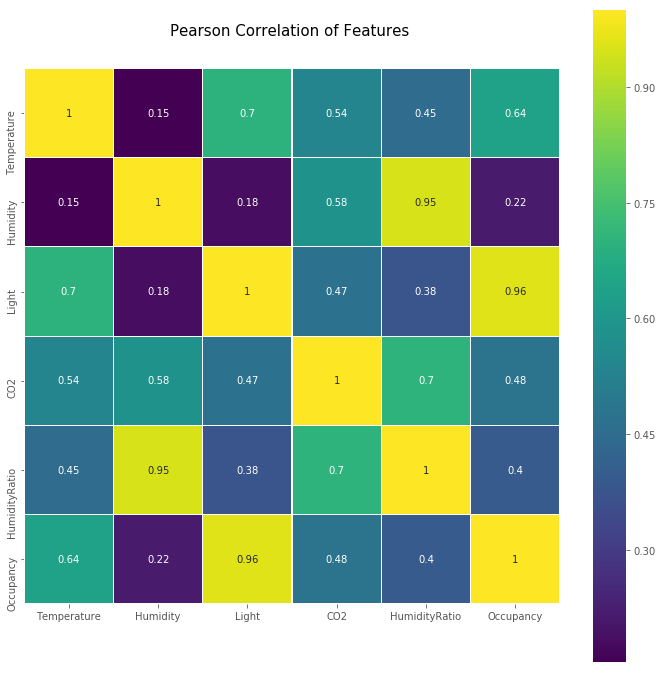




Temperature
Temperature      1.000000
Light            0.697309
CO2              0.540493
HumidityRatio    0.451194
Occupancy        0.643159
weekday_6       -0.471933
Name: Temperature, dtype: float64



Humidity
Humidity         1.000000
CO2              0.583024
HumidityRatio    0.950233
weekday_4       -0.614840
Name: Humidity, dtype: float64



Light
Temperature    0.697309
Light          1.000000
CO2            0.471548
Occupancy      0.960274
Name: Light, dtype: float64



CO2
Temperature      0.540493
Humidity         0.583024
Light            0.471548
CO2              1.000000
HumidityRatio    0.702124
Occupancy        0.477931
Name: CO2, dtype: float64



HumidityRatio
Temperature      0.451194
Humidity         0.950233
CO2              0.702124
HumidityRatio    1.000000
weekday_4       -0.575822
Name: HumidityRatio, dtype: float64



Occupancy
Temperature    0.643159
Light          0.960274
CO2            0.477931
Occupancy      1.000000
Name: Occupancy, dtype: float64


In [445]:
# Let's get a sense of the dependencies between our sensor data by examining descriptives and correlations for measurement data
print('Descriptives:\n')
print(dfCorr.iloc[:,0:6].describe())
print('\n\nMissing value counts:\n')
print(dfCorr.iloc[:,0:6].isnull().sum())
print('\n\nFeature correlations:\n')

# Plot correlation of each of the features with every other feature 
dfPlot = dfCorr.iloc[:,0:6]
correlation_heatmap(dfPlot)

# Let's see if any correlations greater than .4 or smaller than -.4 exist between sensor measurement data and time data
dfTimecorr = dfCorr.corr()
dfTimecorr = dfTimecorr.iloc[:,0:6]
for col in dfTimecorr:
    print('\n\n')
    print(col)
    print(dfTimecorr.loc[((dfTimecorr[col]>.4)|(dfTimecorr[col]<-.4)), col])

Temperature


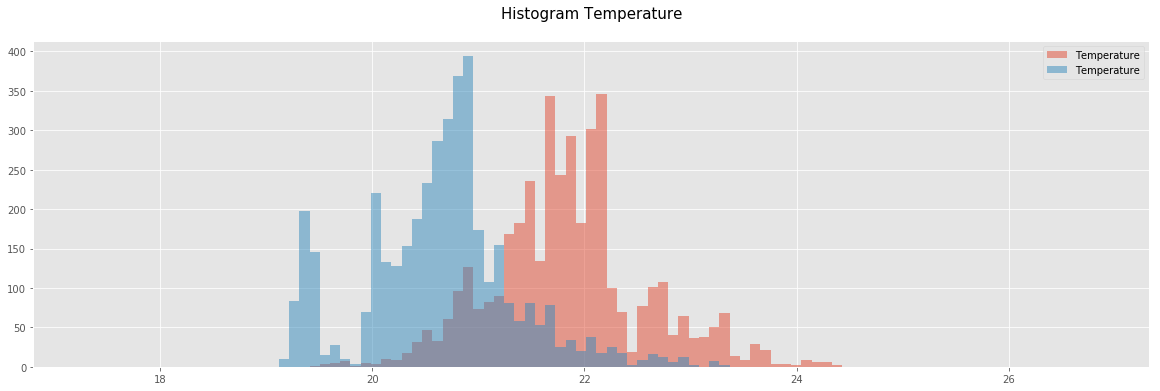

Light


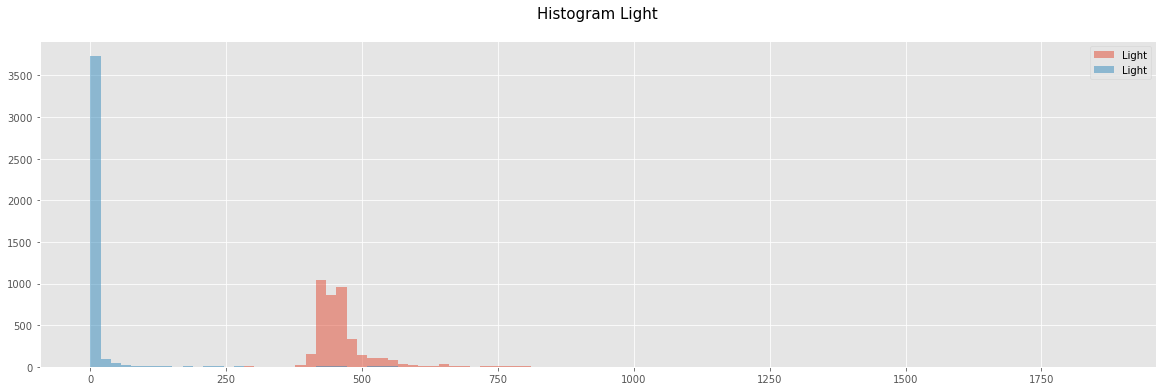

CO2


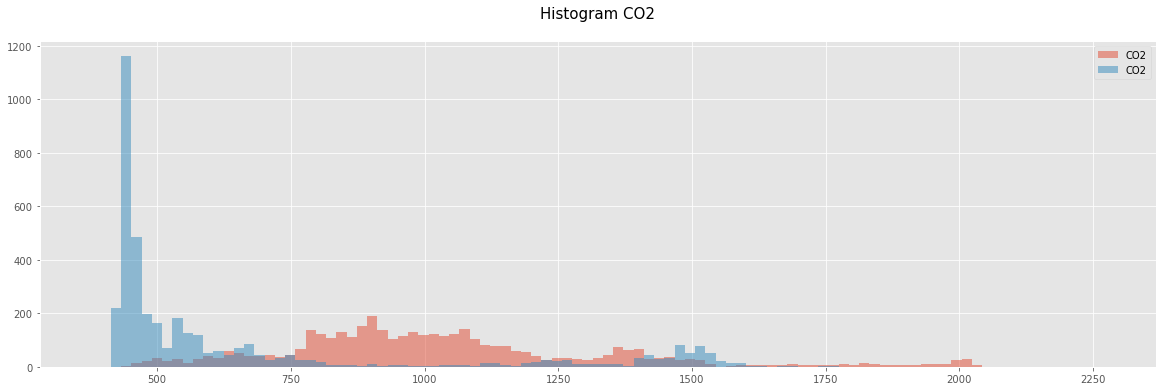

HumidityRatio


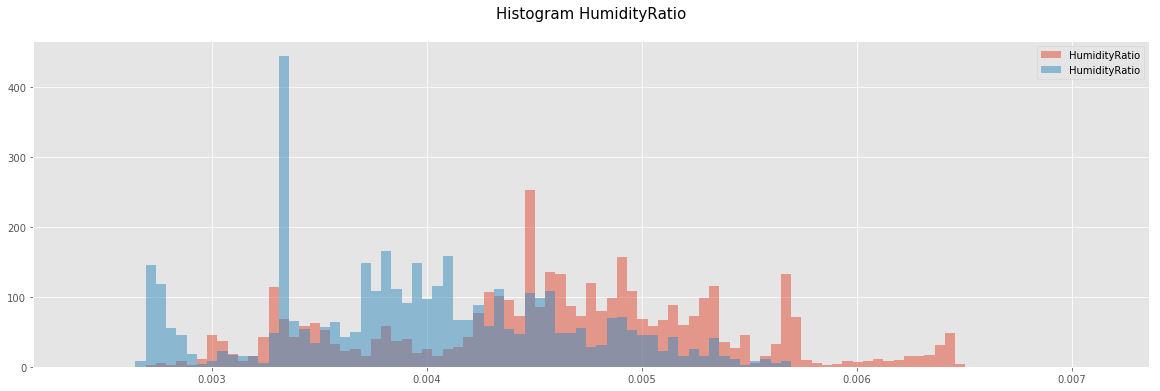

In [446]:
# Based on the correlations above, we can drop the 'Humidity' feature from the model. 
# The 'Humidity ratio' feature is derived from this feature, but unlike 'Humidity ratio', 'Humidity' is not correlated with our target.
# By excluding 'Humidity', we prevent that shared variance between 'Humidity' and 'Humidity Ratio' distorts effects of variance-dependent techniques like Principal Component Analysis. 
# Doing so also allows our model to become more simple.

dfCorr = dfCorr.drop('Humidity', axis=1)

# Next, let's plot histograms for each feature that was originally in the DataFrame organized by occupancy to visualize relationships
plt.close('all')
numvar_hist(dfCorr.iloc[:,0:5], 'Occupancy')


Light


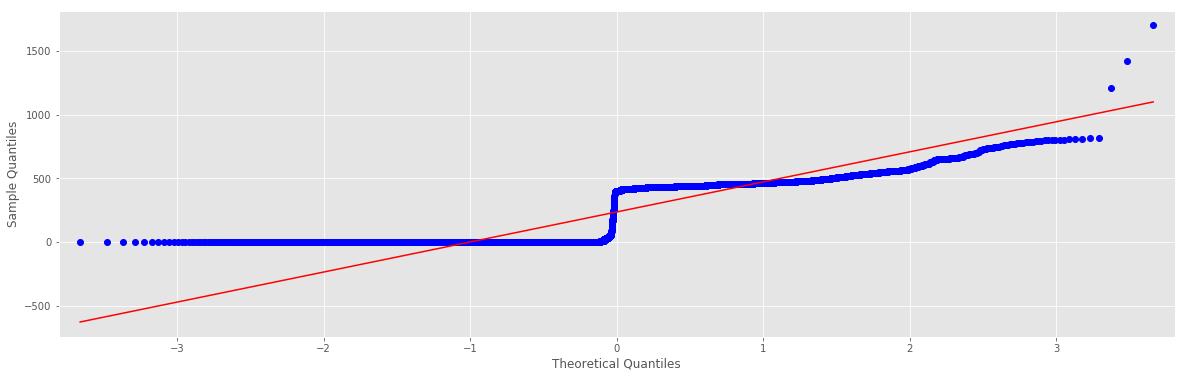

CO2


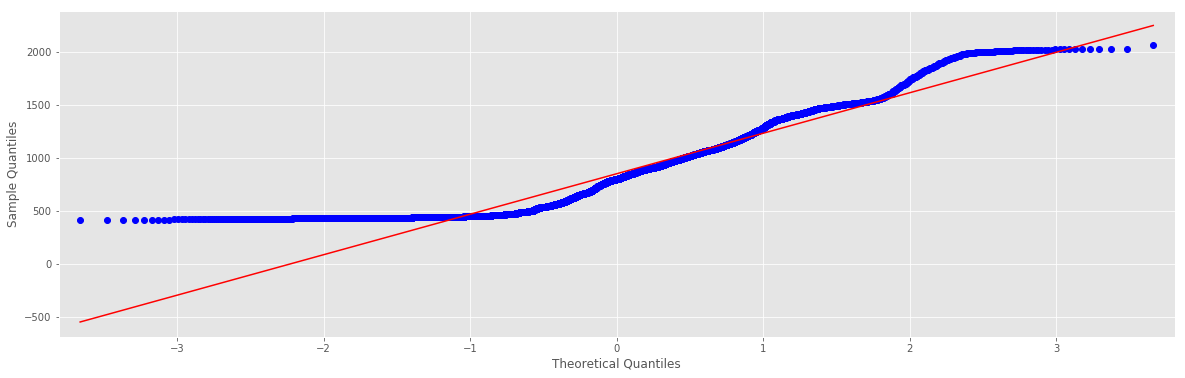

HumidityRatio


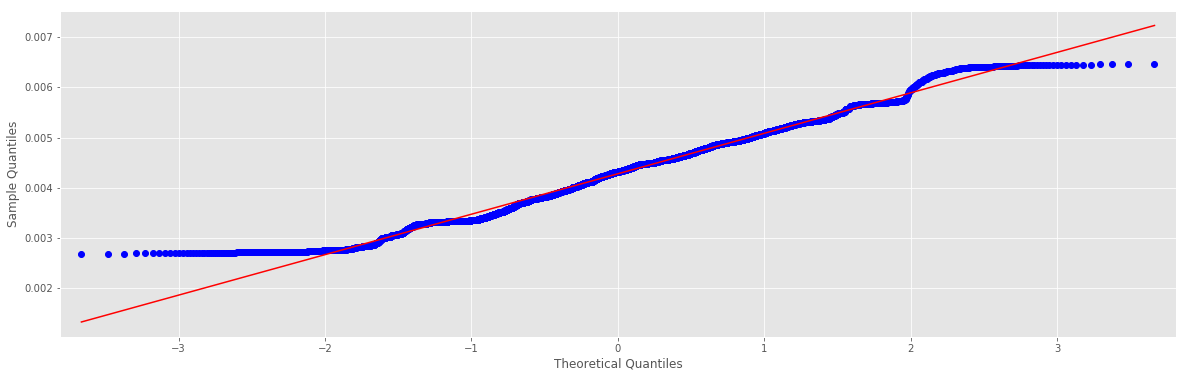

Occupancy


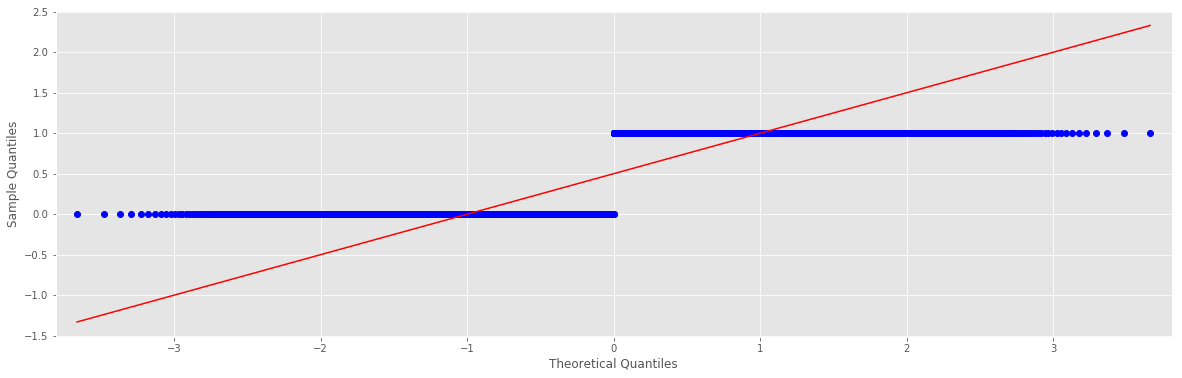

In [447]:
# For a more formal check of normality, we can also plot a QQ plot, which depicts a the comparison between our observations and a probability distribution.
for col in dfCorr.iloc[:,1:5].columns:
    print(col)
    qqplot(dfCorr[col], line='s')
    plt.show()
    plt.clf()

Light_log


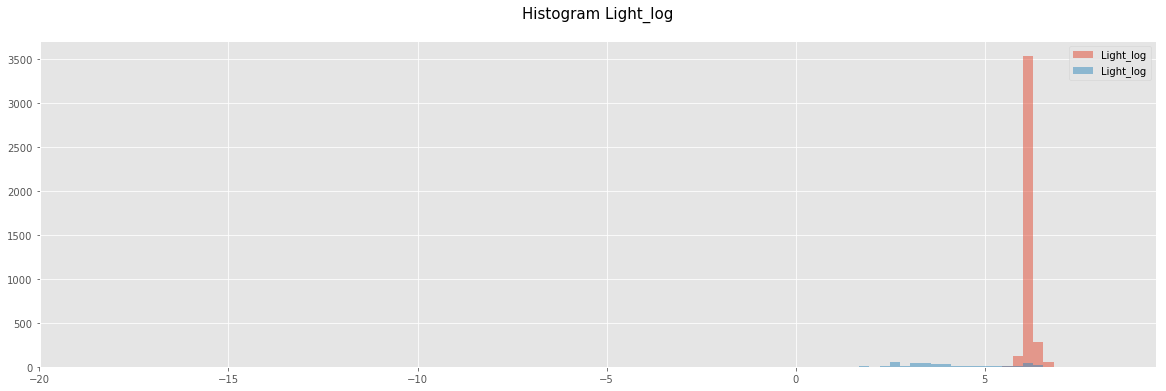

CO2_log


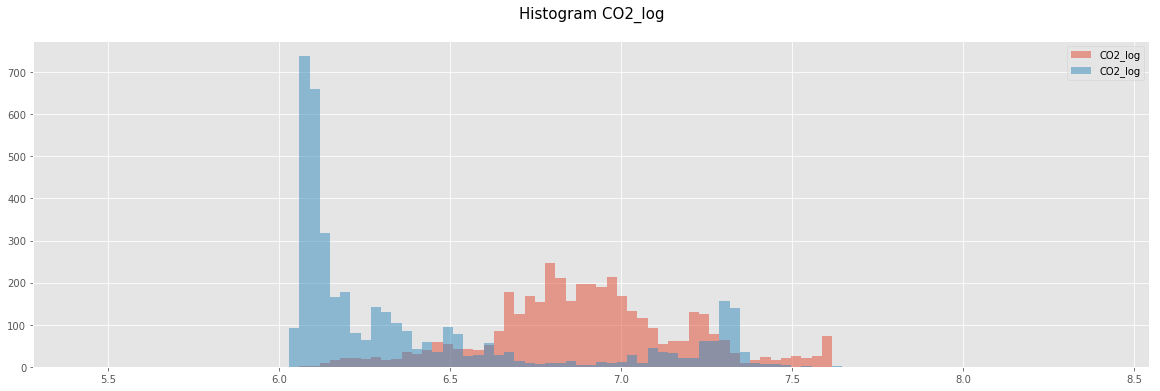

Light_sqrt


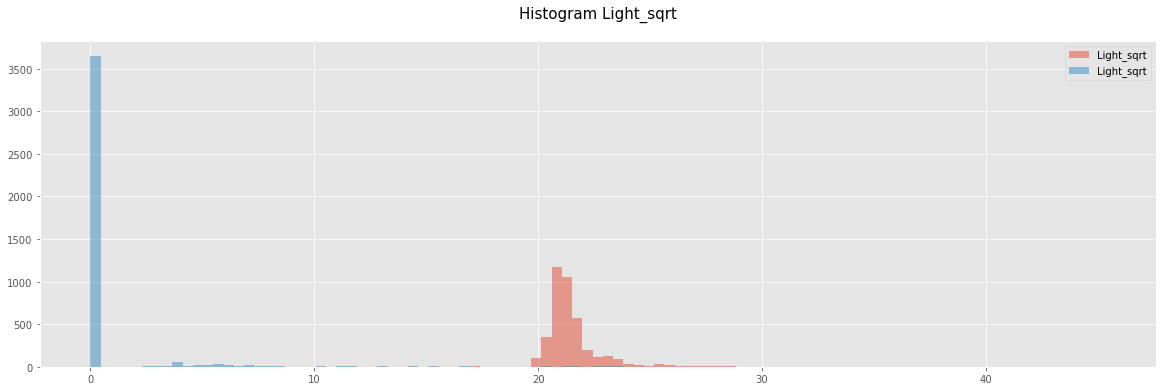

CO2_sqrt


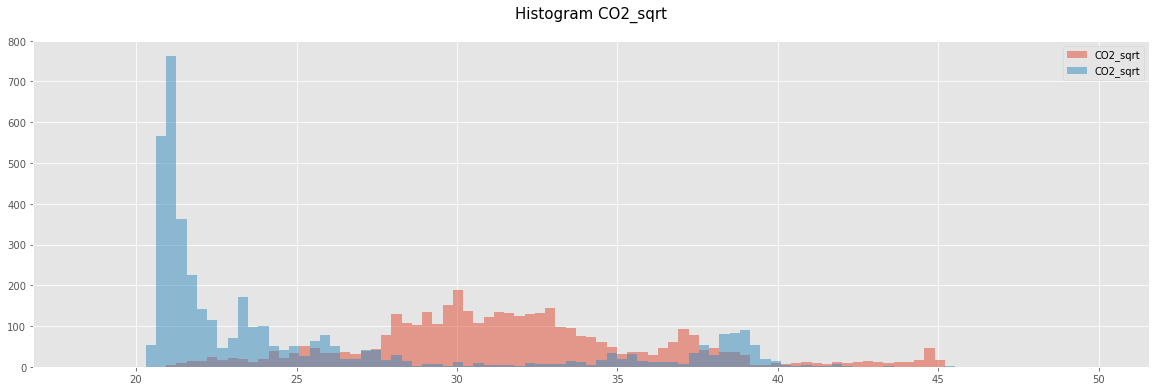

In [448]:
# We can see that the measurements for features 'Light' and 'CO2' are not normally distributed. 
# Fortunately, this is not a problem when using a Support Vector Classifier, 
# as it applies the probability distribution to the geometrical positions of observations relative to a kernel in multidimensional space,
# rather than on the scores of each of the features separately.
# We can still attempt to normalize these features as follows:

dfCorr.loc[dfCorr['Light']==0, 'Light']=0.000000001
dfCorr.loc[dfCorr['CO2']==0, 'CO2']=0.000000001

dfCorr['Light_log'] = np.log(dfCorr['Light'])
dfCorr['CO2_log'] = np.log(dfCorr['CO2'])

dfCorr['Light_sqrt'] = np.sqrt(dfCorr['Light'])
dfCorr['CO2_sqrt'] = np.sqrt(dfCorr['CO2'])

plt.close('all')
numvar_hist(dfCorr.loc[:,['Light_log', 'CO2_log', 'Light_sqrt', 'CO2_sqrt', 'Occupancy']], 'Occupancy')

dfCorr = dfCorr.drop(['Light_log', 'CO2_log', 'Light_sqrt', 'CO2_sqrt'], axis=1)
# As we can see in the plots, neither type of transformation yields improvement toward normality for Light or CO2 variables
# Tried with variations of root (**(1./<coefficient>)) and power **<coefficient>)


In [449]:
# To view a scale-independent depiction of multivariate feature space, we can now plot andrews curves. 
# numvar_andrews_curves(dfCorr, 'Occupancy') #Commented out due to calculation load


## Feature selection and representation ##
After deciding to leave humidity out of our model, we have four indicators which correlate with ocupancy (Light, Temperature, CO2, and Humidity ratio). The most parsimonious model out of these variables would likely be one based on 'Light' alone, as this feature has a correlation of .95 to our target 'Occupancy'.

In modeling this problem, model parsimony (including 'Light' as the only variable) trades off with sensor validity, the extent to which the model can handle errors in measurement by one or more sensors. To illustrate, suppose we build a model that depends exclusively on whether or not a room has a certain value of light in lux. 

It's 18:00 PM, the guys in our measurement office go home for the day, and the last one forgets to turn off the light. Our model is now essentially receiving sensor ratings that are not valid, i.e. do not accurately reflect our criterion of interest. If our model includes just one factor it will be dependent on this factor only, if our model includes four factors, the combined variance of the other three factors may allow the model to compensate for the erroneous sinformation from one of the sensors. A model based on our four sensors therefore seems preferable.

### Dimension optimization ###
From our correlation matrix, it becomes clear that some of our sensor ratings tend to go together. This makes it difficult to assess their unique contributions to the 'Occupancy' variable. We don't know to what extent the correlations between each feature and 'Occupancy' are due to covariance between our features. 

A technique called principle component analysis involves finding dimensions on which the variance explained in the dataset is maximized, but which are independent of other dimensions found (based on the distance of the projected dimension to each of the observations). It is a linear decomposition technique, meaning that the dimensions projected are straight lines.

We can use principle component analysis to reduce the continuous features in our feature set to a (same-size or smaller) set of linearly independent features, which contain all of the variance from the original four continuous features, but are statistically independent from each other. 

We will have a bit more difficulty in interpreting our final results because we have to recalculate coefficients for each of our components back to our original features, but we get accurate contributions for each derived component in return, along with a reduced-size feature set if desirable (although the dichotomous indicators we added to represent time effects make feature reduction difficult in the current feature set). 

Because we have seen that some of our continuous variables are not normally distributed, we need to make sure our continuous data follow a multivariate normal distribution before we can apply principal component analysis to them.  

In [450]:
# Subset features and scale them

dfCorr = dfCorr.reset_index(drop=True)
y = dfCorr['Occupancy']
X = dfCorr.drop(['Occupancy'], axis=1)
X = scale_features_df(X)
tmp = X.iloc[:,0:3]

# Check if feature set has multivariate normality

dimmean = np.mean(tmp, axis=0)
dimcov = tmp.cov()

mvnorm = pd.Series(multivariate_normal.pdf(tmp, mean=dimmean, cov=dimcov)).sort_values()
print('Multivariate normality if statistic < .05: ')
print(mvnorm.max())
print('Number of violations out of ' + str(mvnorm.shape[0]) + ' observations: ')
print(mvnorm.loc[mvnorm > .05].count())
# At a maximum value of .12, which exceeds the conventional .05 threshold, the multivariate normality assumption is not strong.

('New Variances:\n', Temperature      1.000125
Light            1.000125
CO2              1.000125
HumidityRatio    1.000125
weekday_0        1.000125
weekday_1        1.000125
weekday_2        1.000125
weekday_3        1.000125
weekday_4        1.000125
weekday_6        1.000125
hour_0           1.000125
hour_1           1.000125
hour_2           1.000125
hour_3           1.000125
hour_4           1.000125
hour_5           1.000125
hour_6           1.000125
hour_7           1.000125
hour_8           1.000125
hour_9           1.000125
hour_10          1.000125
hour_11          1.000125
hour_12          1.000125
hour_13          1.000125
hour_14          1.000125
hour_15          1.000125
hour_16          1.000125
hour_17          1.000125
hour_18          1.000125
hour_19          1.000125
                   ...   
minute_31        1.000125
minute_32        1.000125
minute_33        1.000125
minute_34        1.000125
minute_35        1.000125
minute_36        1.000125
minute_37        

Given that we cannot make a strong assumption of multivariate normality, we can apply principal component analysis, but we'll have to keep in mind that the linear decomposition of the feature space will fail to capture non-linear effects that may exist (as evidenced by the violation of assumptions of multivariate non-normality).

As feature reduction is not a goal of our decomposition, let's decompose  the continuous features in our feature space into the same number of features. In effect, we are only re-distributing variance to a most optimal configuration of linearly independent predictors. 

('Variance explained by derived components: ', array([ 3.70243463,  1.79772414,  1.45802314,  1.34749829]))


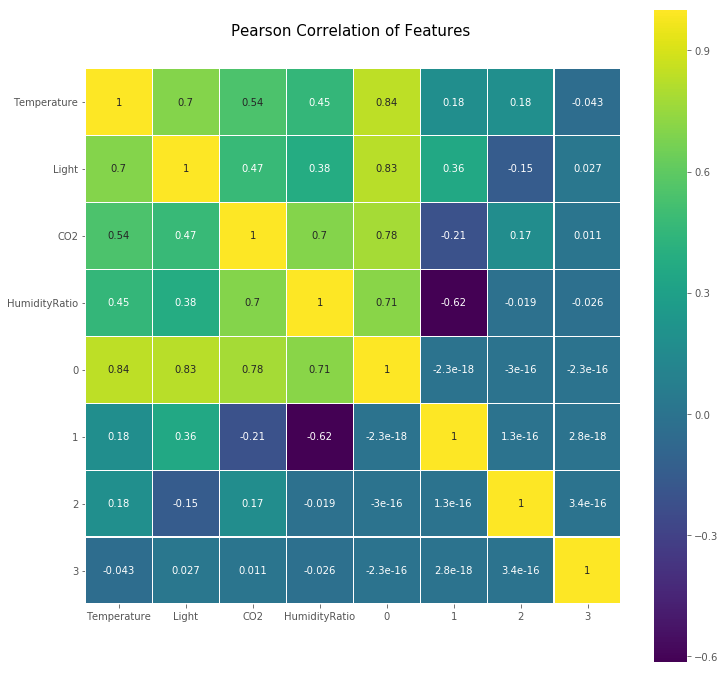

In [451]:
# Apply PCA to continuous features in feature space.
from sklearn.decomposition import PCA
X_continuous = X.iloc[:,0:4]
pca = PCA(n_components = X_continuous.shape[1])
pca_4 = pca.fit(X_continuous)
pca_T = pca.fit_transform(X)
print("Variance explained by derived components: ", pca_4.explained_variance_)

#Correlate resulting components with original features
plot_correlations = pd.concat([X.iloc[:,0:4], pd.DataFrame(pca_T)], axis=1)
correlation_heatmap(plot_correlations)


## Principal Component Analysis ##

If we look at the relation between the original variables (upper left quadrant), we've seen these before in an earlier heatmap. The relations between the components 0 through 7, that resulted from the PCA (lower right quadrant) all approach 0, reflecting statistical independence of orthagonal components. 

If we look at the lower left or upper right quadrants (they are mirrored across the diagonal), we can see that the most important predictor is a combination of high temperature, a lot of light, a lot of CO2, and a high humidity ratio. The second component is the absence of humidity in the presence of temperature and light. The third and fourth components do not seem to relate meaningfully to the original components in terms of variance. 



('Features by importance:\n', [(2.267042779067527, 'HumidityRatio'), (2.019300220854, 'Light'), (1.8494776803438293, 'Temperature'), (1.7647856985164667, 'CO2')])


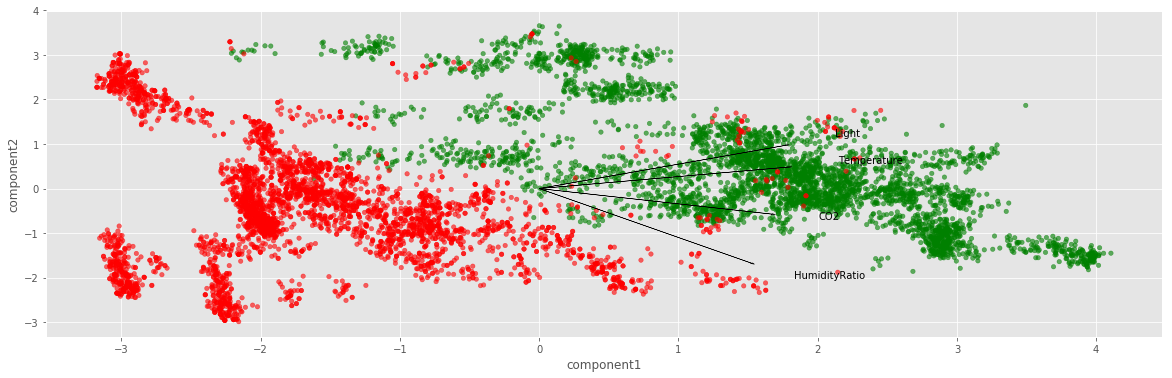

In [452]:
# We can visualize how effective PCA was in finding components in the data set, and visualize relations between component socres and occupancy
ax = draw_vectors(pca_T, pca.components_, X_continuous.columns.values, plt)
T  = pd.DataFrame(pca_T)

T.columns = ['component1', 'component2', 'component3', 'component4']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=.60, ax=ax)

plt.show()


## Graph under Principal Component Analysis ##

It seems that for the moments at which the room is occupied, we get two clusters of values. One scores relatively high on component 2, and low to moderate on component 1, the other scores high on component 1, but relatively low on component 2. Note that when SMOTE is used, the number of green points in the graph is higher than it would normally be, as we have oversampled the 'occupied' category, and when undersampling is used the number of red poits is lower than it would normally be as we have undersampeled the 'not occupied' category.

We can interpret the correlations between the components and the original variables in the data set. All values for the features that correlate with components 1 and 2 (higher values for all sensor readings for component 1, and higher light and temperature values, but lower humidity readings (in ratio) for component 2) are, on average, higher for occupied rooms than they are for non-occupied rooms. 

It is important to recognize that the graph constructed here only displays the first two components of the data set, or, in other words, the first two dimensions of the n-dimensional space. Plots can also be made for the remaining components, but as the components are ordered by the amount of variance they explain this graph depicts the two most important components in terms of variance and is therefore the most informative. 


In [453]:
# Create new feature set using PCA results
tmp = X.iloc[:,4:]
X = pd.concat([T, tmp], axis=1)
dfUse = pd.concat([X, y], axis=1)
# numvar_andrews_curves(dfUse, 'Occupancy') #Commented out due to calculation load

In [454]:
# Define training and testing subsets
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfUse, test_size = .4, stratify=dfUse['Occupancy'])
test, validate = train_test_split(test, test_size = .5, stratify=test['Occupancy'])
X_train = train.drop('Occupancy', axis=1)
y_train = train['Occupancy']
X_test = test.drop('Occupancy', axis = 1)
y_test = test['Occupancy']
X_val = validate.drop('Occupancy', axis = 1)
y_val = validate['Occupancy']

In [455]:
# Fit predictive model to training set, examine evaluation metrics
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Calculate the initial fit of the model, and print diagnostics
if (WeightOrSample==0)|(WeightOrSample==2):
    clf = SVC(kernel = 'linear')
    svm = clf.fit(X_train,y_train)
    print('Initial training score: '+str(svm.score(X_train,y_train)))
    print('Initial test score: '+ str(svm.score(X_test,y_test)))
    y_pred = svm.predict(X_test)
    print('Classification report: ' + str(classification_report(y_test, y_pred)))
    print('Confusion matrix: ' + str(confusion_matrix(y_test, y_pred)))
    
elif WeightOrSample==1:
    clf = SVC(kernel = 'linear', class_weight = 'balanced')
    svm = clf.fit(X_train,y_train)
    print('Initial training score: ', str(svm.score(X_train,y_train)))
    print('Initial test score: ', str(svm.score(X_test,y_test)))
    y_pred = svm.predict(X_test)
    print('Classification report: ' + str(classification_report(y_test, y_pred)))
    print('Confusion matrix: ' + str(confusion_matrix(y_test, y_pred)))

 

Initial training score: 0.990652264229
Initial test score: 0.990654205607
Classification report:              precision    recall  f1-score   support

          0       1.00      0.98      0.99       803
          1       0.98      1.00      0.99       802

avg / total       0.99      0.99      0.99      1605

Confusion matrix: [[789  14]
 [  1 801]]


It seems our model, which has not been tuned yet, is performing quite well on the training data:
* For the parameter weighting approach, the training score was .99, with 36 errors out of 2960 classified data points
* For the oversampling approach, the training score was .99, with 39 errors out of 4314 classified data points
* For the undersampling approach, the training score was .99, with 14 errors out of 1605 classified data points

Let's examine its performance at various levels of C and using cross-validation, so that we can assess whether its good performance is due to overfitting of the training data. If it is, we would expect lower test set performance than training set performance.

In [456]:
# Please note this next step will take some time to execute!
# Use GridSearchCV to search for optimal parameter values and assess potential overfitting by implementing cross-validation

# Tune hyperparameters C and gamma to avoid overfitting
params = [{'C': [.00001, .0001, .001, .01, 1, 10], 'gamma':[.00001, .0001, .001, .01, 1, 10]}] # Optional: Change kernel using ",'kernel':['rbf', 'poly', 'linear', 'sigmoid']". Left out to lessen calculation time, as 'rbf' proved optimal in a more complete run. 
if (WeightOrSample==0)|(WeightOrSample==2):
    clf2 = GridSearchCV(SVC(), params, refit=True)
elif WeightOrSample==1:
    clf2 = GridSearchCV(SVC(class_weight = 'balanced'), params, refit=True)

# Fit optimal model
svm2 = clf2.fit(X_train, y_train)
scores = pd.Series(svm2.cv_results_['mean_train_score'])

#Save best estimator for future use
bestEst = svm2.best_estimator_

In [457]:
# Let's print the results of our training session

for key in svm2.cv_results_:
    print(key)
    print(svm2.cv_results_[key])
    print('\n\n')
print("Best estimation: " + str(svm2.best_estimator_))
print('\n')
print("Best test score achieved:" + str(svm2.best_score_))
print('\n')
print("Average accuracy across models: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

std_train_score
[ 0.00332457  0.00320932  0.00280349  0.00210687  0.0012718   0.18024838
  0.00332457  0.00320932  0.00280349  0.00210687  0.0012718   0.18024838
  0.00332457  0.00320932  0.00280349  0.00210687  0.0012718   0.18024838
  0.00332457  0.00320932  0.00280349  0.00210687  0.0012718   0.18024838
  0.00332457  0.00257991  0.00217213  0.0030161   0.00029371  0.
  0.00232952  0.00217213  0.00116652  0.00025388  0.          0.        ]



rank_test_score
[16 21 12  8 27 33 16 21 12  8 27 33 16 21 12  8 27 33 16 21 12  8 27 33 16
  5  6  3 26 32  4  6  1  2 25 31]



split0_train_score
[ 0.95822943  0.95822943  0.95854115  0.96103491  0.99750623  0.61814214
  0.95822943  0.95822943  0.95854115  0.96103491  0.99750623  0.61814214
  0.95822943  0.95822943  0.95854115  0.96103491  0.99750623  0.61814214
  0.95822943  0.95822943  0.95854115  0.96103491  0.99750623  0.61814214
  0.95822943  0.96851621  0.96103491  0.97880299  1.          1.
  0.96851621  0.96103491  0.98410224  0.9981

### Performance for parameter weighting
Best performing model was:

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Best test score: .985


### Performance for oversampling

Best performing model was: 

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
  
Best test score: .989

### Performance for undersampling

Best performing model was:

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Best test score: .978


The best model seems to be performing well for each type of analysis, with an accuracy of >.97 in all cases. At the same time, the training and testing data from the cross-validation rounds show that we have still not been able to exclude the possibility of overfitting. 

The gamma parameter is equal to .001 for all types of analysis, which means the data points in our sample have a reasonable sphere of influence (i.e. impact on the probabilities of their nearest neighbours) in model calculation. 

We can't yet say whether this model is overfitting. At 10, the value for the C parameter is relatively high, meaning little regularization is used. Because we have few training features, however, the impact of the regularization can also be expected to be less pronounced than in a model which does have a large number of features.

Next, let's test the performance of our estimator on the validation set. This should inform us about the extent to which the model overfits.

In [458]:
# Use the optimal estimator to predict the validation set
y_pred = svm2.predict(X_val)

# Evaluate the predictions
print('Test score: ' + str(svm2.score(X_val, y_val)))
print('\n')
print('Classification report: ' + str(classification_report(y_val, y_pred)))
print('\n')
print('Confusion matrix: ' + '\n' + str(confusion_matrix(y_val, y_pred)))

Test score: 0.981308411215


Classification report:              precision    recall  f1-score   support

          0       0.99      0.98      0.98       802
          1       0.98      0.99      0.98       803

avg / total       0.98      0.98      0.98      1605



Confusion matrix: 
[[782  20]
 [ 10 793]]


### Parameter weighting

Score on validation set: .99

35 classification errors in 2960 classifications.


### Oversampling

Score on validation set: .990

41 classification errors in 4315 classifications.

### Undersampling

Score on validation set: .982

29 classification errors in 1605 classifications.

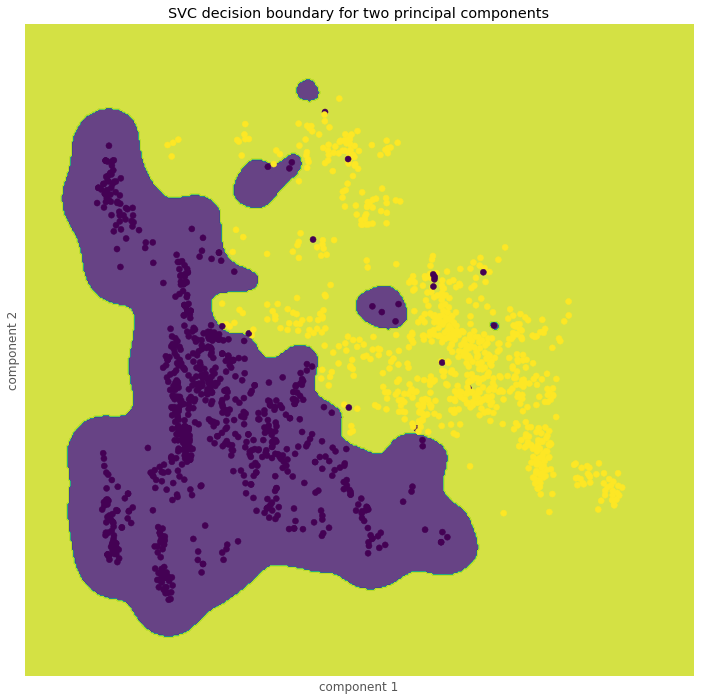

In [459]:
# Plot decision function on the principal two components in the optimal model
decision_function_2f(svm2, X_val, y_val)

Here, we can see the decision boundaries for the two principal components of the model plotted. Some of the data points still seem to fall in the decision space of the other color. This partly shows the influence of the other components, and may partly be attributed to our inability to capture a high-dimensional space accurately in a 2-dimensional plot.

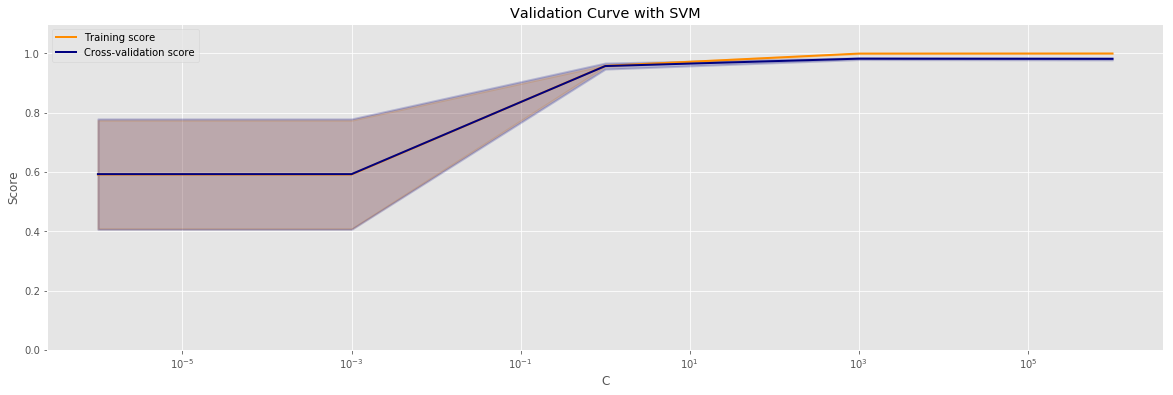

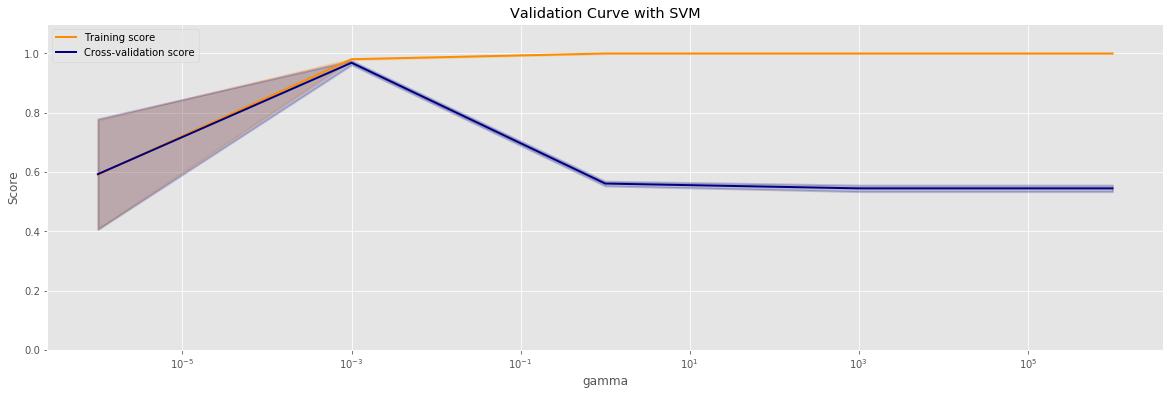

In [460]:
# Please note this step will take some time to execute!
# Having examined various classification metrics and the confusion matrix, we can also view validation curves for the various parameters in the model, based on test set performance.
from sklearn.model_selection import validation_curve

parameterList = ['C', 'gamma']
plot_validation_curve(bestEst, X_val, y_val)


### Validation curves

The validation curves for the parameter weighting, oversmapling and undersampling approaches look similar. This is to be expected, as differences in the underlying data points are based on randomized changes, ensuring that effects on the data points from the original data set are equally distributed. 

The curves show that a C of 10 is the point at which where both testing and cross-validation curves decrease their incline markedly, because they near the maximum value of 1.0. As we increase the C parameter, we reduce the width of the margin that the support vector machine is solving for, by selecting only the most influential (i.e. margin-defining) support vectors. This leads to the inclusion of less data points in calculation of the margin (only those closest to the optimal margin) for determining the margin's location. We can see in the plot that at C = 10, we near the optimal weighting of support vectors for this model.

For the gamma value, the curves for both training and cross-validation performance incline until a value of .001. Beyond this point (i.e. for larger values of gamma) performance on the training set stays constant. Gamma controls the tradeoff between variance and bias. This plot shows that as gamma increases beyond .001 and the range of the rbf kernel decreases, performance on the training set does not suffer. However, performance on the cross-validation set does drop, because the prediction of new data points from the validation set becomes more difficult for the trained model is the range of the rbf kernel becomes smaller.

## Comparing parameter weighting, oversampling, and undersampling ##

In this notebook, we have been comparing three techniques for dealing with imbalanced data. All in all, the differences observed between the three methods are minimal to non-existent. Perhaps this is because the imbalance was slight (+/- 25% positive target observations and +/- 75% negative target observations), perhaps differences did not become apparent because the fitted models neared optimal performance. When considering continuous measurement in the case of real-time room occupancy predictions, the current data suggests all three methods could be used. 

Both oversampling and undersampling involve manipulating the number of data points underlying the model. This will lead parameter estimates be higher than those that would be obtained on the full dataset, as it becomes easier for the model to discriminate between occupied and non-occupied rooms. Weighting the C parameter has a similar effect, but does so by adjusting the impact of the vectors (the C parameter) so that the margin is not influenced disproportionally by the difference in group size. 

For predictions which involve a decomposition of time series, it is important to realize that manipulating the data points will either generate additional points at certain time stamps, or randomly remove certain timestamps from the dataset. Either of these solutions will create discontinuity in the time series, making it impossible to reliably estimate effects of time. If we would want to use a support vector machine to make continuous predictions of room occupancy, it seems best to implement the parameter weighting approach.



## Broader considerations ##

Our feature set is likely based on measures in the one office space (training and test) with periods which are about equal in length. Also, we we do not know the number of people who were present or the size of the room. Finally, time effects were explicitly not taken into account in the current modeling excercise, even though a clear seasonal trend was visible. The reason for this is that it was difficult to model multiple seasonality given a limited period of measurement. 

The current data sets are standardized in that the same office space and sensors were used, the same number of people may have been present, and measurements were taken in two consecutive time periods. It will be interesting to see if reliable predictions can be derived from datasets in which these factors have changed.

In closing, if we would want to move toward a reliable detection system that functions independent of measurement time, room size and type, and number of people present, we'll need to calibrate our measurement system for the measurement goals and situation at hand (i.e. matching the sensitivity of our sensors to the environmental parameters that can affect the quantities used in the current dataset, and / or improving our system's predictions based on a more diverse sampling of rooms and numbers of people). 

In truth, we should use a different classifier, such as a random forest or similar boosted decision tree model (which does not require features to have a Gaussian distribution,  either and is faster to calculate). If we insist on using a support vector machine, however, this notebook shows how it can be used to good effect.  